In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from numpy import array as arr
from numpy import transpose as tr
# import h5py
# import pickle

import ipywidgets as widgets

mpl.rcParams['image.origin']='lower'
mpl.rcParams['image.aspect']='auto'
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=True


# Définition des classes

In [8]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

class ray:
    def __init__(self, x, y, thetax, thetay, w0, sigma=1, z=0, wl=1030, M2=1):
        '''
        Initialise le rayon à une position sur le miroir 1, avec un angle.
        On lui donne son waist au foyer, et la distance entre ce foyer et le miroir (z).
        /!\ : z=0 signifie que le foyer est sur le miroir ! 
        Le waist donné est celui non-linéaire, qu'on espère avoir en fonctionnement optimal de la cellule.
        '''
        self.x = x
        self.y = y
        self.thetax = thetax
        self.thetay = thetay
        self.wavelength = wl
        self.sigma = sigma
        self.M2 = M2

        self.q = z + 1j*w0**2 * np.pi/self.wavelength
        self.qnl = z + 1j*w0**2 * np.pi/self.wavelength / np.sqrt(self.sigma)

    def propagation(self, l):
        self.x += l*self.thetax
        self.y += l*self.thetay
        self.q += l
        self.qnl += l
    
    def mirror(self, Roc):
        self.thetax -= 2*self.x/Roc
        self.thetay -= 2*self.y/Roc
        self.q = self.q/(1-2/Roc*self.q)
        self.qnl = self.qnl/(1-2/Roc*self.qnl)

    def translate_to_polar(self):
        return cart2pol(self.x, self.y)

    def waist0(self):
        return(np.sqrt(np.imag(self.qnl)/np.pi*self.wavelength*np.sqrt(self.sigma))* np.sqrt(self.M2))

    def waist(self):
        return(1/np.sqrt(np.imag(-1/self.qnl) *np.pi/np.sqrt(self.sigma)/self.wavelength)* np.sqrt(self.M2))

class cavity:
    def __init__(self, L, RCmirror, Rmirror, reflectivity=1, pressure=1, n0=1, n2=0, d=1, sc=1):
        self.length = L
        self.radius = Rmirror
        self.roc = RCmirror
        self.pressure = pressure
        self.n0 = n0
        self.n2 = n2
        self.distance_to_window = d
        self.sc = sc
        self.reflectivity = reflectivity


    def injection_laser(self, x_in, y_in, thetax_in, thetay_in, E, wl, w0, tau0, z=0, M2=1):
        self.x_in = x_in
        self.y_in = y_in
        self.thetax_in = thetax_in
        self.thetay_in = thetay_in

        self.beam_wavelength = wl
        self.beam_energy = E
        self.beam_waist_size = w0
        self.beam_focus_pos = z
        self.tau0 = tau0
        self.beam_M2 = M2

        self.tau_eff = tau0 * np.sqrt(np.pi/(np.log(8)))
        self.power = self.beam_energy / self.tau0
        self.Peff = self.beam_energy / self.tau_eff
        self.Pcrit = 3.77*self.beam_wavelength**2/(8*np.pi*self.pressure*self.n2)
        self.sigma = 1 - self.power/self.Pcrit /np.sqrt(2)
        self.Bint = 0
        self.BintViotti = 0
        self.b = 0

        if self.sigma <= 0:
            print('The peak power is over the critical power. \n Look at what you did wrong')
 
    def optimize_waist(self):
        self.beam_waist_size = np.sqrt(self.beam_wavelength*self.length/(2*np.pi)*np.sqrt(self.sigma*(2*self.roc/self.length-1)))
        return(self.beam_waist_size)

    def waists(self, show=True):
        Ray_test = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2 = self.beam_M2)
        
        waist_mirror = Ray_test.waist()
        Fl = self.beam_energy / (waist_mirror**2 * np.pi * self.beam_M2)
        #Sometimes there is a /2 on the effective area, which doubles the fluence, but sometimes not. I don't know who to believe.

        if show:
            print(f'Waist on mirrors = {waist_mirror*1e6:.1f}µm')
            # print(f'Waist0 on mirrors = {Ray_test.waist0()*1e6}µm')
            Ray_test.propagation(-self.length/2)
            print(f'Waist at focus = {Ray_test.waist()*1e6:.1f}µm')
            # print(f'Waist0 at focus = {Ray_test.waist0()*1e6}µm')
            Ray_test.propagation(-self.distance_to_window)
            print(f'Waist on window = {Ray_test.waist()*1e6:.1f}µm')
            # print(f'Waist0 on window = {Ray_test.waist0()*1e6}µm')
            Ray_test.sigma = 1
            Ray_test.propagation(+self.distance_to_window)
            print(f'Waist at focus at air = {Ray_test.waist()*1e6:.1f}µm')
            # print(f'Waist0 at focus at air = {Ray_test.waist0()*1e6}µm')
            print(f'Fluence on mirrors = {Fl*1e-4} J/cm^2')
        else:
            return(waist_mirror, Fl)


    def propag_MPC(self, N, show=True):
        self.Ray = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2=self.beam_M2)
        energy = self.beam_energy
        self.Bint = 0
        self.BintViotti = 0
        if show:
            f, (ax_M1, ax_cell, ax_M2) = plt.subplots(1,3, figsize=(12,4))
            tax = [ax_M1, ax_cell, ax_M2]
            for ax in tax:
                ax.set_xlim([-self.radius*1.5,self.radius*1.5])
                ax.set_ylim([-self.radius*1.5,self.radius*1.5])
                ax.add_artist(plt.Circle((0,0),self.radius, fill=False))
            self.Ray.propagation(-self.length)
            ax_M2.add_artist(plt.Circle((self.Ray.x, self.Ray.y), self.Ray.waist()*self.sc, color='b'))
            ax_M2.annotate('entry', xy=(self.Ray.x, self.Ray.y), c='r')
            self.Ray.propagation(self.length)

        # self.Ray = ray(self.x_in, self.y_in, self.thetax_in, self.thetay_in, sigma=self.sigma, wl=self.beam_wavelength, z=self.beam_focus_pos, w0=self.beam_waist_size, M2=self.beam_M2)
        self.Ray.mirror(self.roc)
        l_Rcell = []
        l_Rmirror = [self.Ray.translate_to_polar()[0]]
        l_phimirror = [self.Ray.translate_to_polar()[1]]
        l_waist_mirror = []
        l_Bint = []
        self.Bint += self.B_integral(energy=energy)
        self.BintViotti += self.B_integral(energy=energy, Viotti=True)
        
        
        for i in range(N):
            if show:
                (ax_M1, ax_M2)[i%2].add_artist(plt.Circle((self.Ray.x, self.Ray.y), self.Ray.waist()*self.sc, color='k'))
                (ax_M1, ax_M2)[i%2].annotate(str(i), xy=(self.Ray.x, self.Ray.y), c='r')

            l_waist_mirror.append(self.Ray.waist())
            self.Ray.propagation(self.length/2)     #Propagate to the middle of the cell
            l_Rcell.append(self.Ray.translate_to_polar()[0])
            self.Bint += self.B_integral(energy=energy)
            l_Bint.append(self.B_integral(energy=energy))
            self.BintViotti += self.B_integral(energy=energy, Viotti=True)

            if show:
                ax_cell.add_artist(plt.Circle((self.Ray.x, self.Ray.y), self.Ray.waist()*self.sc, color='k'))
            self.Ray.propagation(self.length/2)
            r, phi = self.Ray.translate_to_polar()
            self.Ray.mirror(self.roc)
            l_Rmirror.append(r)
            l_phimirror.append(phi)
            energy *= self.reflectivity
            sigma_i = 1 - energy/self.tau0 / self.Pcrit / np.sqrt(2)
            self.Ray.sigma = sigma_i
        
        if show:
            (ax_M1, ax_M2)[N%2].add_artist(plt.Circle((self.Ray.x, self.Ray.y), self.Ray.waist()*self.sc, color='g'))
            (ax_M1, ax_M2)[N%2].annotate('exit', xy=(self.Ray.x, self.Ray.y), c='r')

        self.b = 7*np.pi * self.n2 * self.pressure * self.power * N / (2 * self.beam_wavelength**2)
        return(arr(l_Rmirror), arr(l_phimirror), arr(l_Rcell), arr(l_waist_mirror), arr(l_Bint))

    def B_integral(self, energy, Viotti=0):
        if not Viotti:
            return 4*np.pi*self.n2*self.pressure/self.beam_wavelength**2 * energy/self.tau0 /np.sqrt(self.sigma*self.beam_M2) * np.arctan(np.sqrt(self.length/(2*self.roc-self.length)))
        else:
            return 2*np.pi**2 * self.n2 * self.pressure * energy/self.tau0 / self.beam_wavelength**2 * np.arccos(1-self.length/self.roc)
    def optimize_angle(self, N, axis=0, mode='sum'):
        
        tab_incr = [1, 0.1, 0.01, 0.01]
        startVal = 0
        R_in = np.sqrt(self.x_in**2+self.y_in**2)
        for j in range(len(tab_incr)):
            incr = tab_incr[j]

            t = []
            tab_angles = np.linspace(startVal-incr, startVal+incr, 100)
            for i in range(len(tab_angles)):
                if axis==0:
                    self.thetax_in = tab_angles[i]
                elif axis==1:
                    self.thetay_in = tab_angles[i]
                l_Rmirror, *_ = self.propag_MPC(N, show=False)
                if mode=='sum':
                    t.append(np.sum(l_Rmirror))
                elif mode=='var':
                    t.append(np.sum(np.var(l_Rmirror-R_in)))

            i1 = np.argmin(t)
            startVal = tab_angles[i1]
        if axis==0:
            self.thetax_in = tab_angles[i1]
        elif axis==1:
            self.thetay_in = tab_angles[i1]

    def optimize_injection(self, N):
        self.optimize_angle(N, 0, 'sum')
        self.optimize_angle(N, 1, 'var')
        self.optimize_angle(N, 0, 'var')



# Paramètres et affichage

In [23]:
if 1:
    Rmirror = 25.7  #En mm

    slider_N =          widgets.IntSlider(min=1, max=50, step=1, value=25, continuous_update=False)
    slider_x =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=20, continuous_update=False)
    slider_y =          widgets.FloatSlider(min=-Rmirror, max=Rmirror, step=0.1, value=0.0, continuous_update=False)
    slider_thetax =     widgets.FloatSlider(min=-0.2, max=0.2, step=0.01, value=0, continuous_update=False)
    slider_thetay =     widgets.FloatSlider(min=-0.2, max=0.2, step=0.01, value=0, continuous_update=False)
    checkbox_angle =    widgets.Checkbox(value=True)


    slider_energy =     widgets.FloatSlider(min=0, max=10, step=0.1, value=4, continuous_update=False)
    slider_tau =        widgets.FloatSlider(min=100, max=1000, step=10, value=450, continuous_update=False)
    slider_pressure =   widgets.FloatSlider(min=0, max=5, step=0.1, value=1, continuous_update=False)
    slider_rmirror =    widgets.FloatSlider(min=12, max=100, step=0.1, value=25.4, continuous_update=False)
    slider_roc =        widgets.FloatSlider(min=0.1, max=2, step=0.01, value=0.75, continuous_update=False)
    slider_L =          widgets.FloatSlider(min=0, max=2*slider_roc.value-0.001, step=0.001, value=1.481, continuous_update=False)
    slider_waist =      widgets.FloatSlider(min=50, max=1000, step=1, value=165, continuous_update=False)
    checkbox_waist =    widgets.Checkbox(value=True)

    def update_L_range(*args):
        slider_L.max = 2*slider_roc.value-0.001
    slider_roc.observe(update_L_range, 'value')


    def MPC(N=slider_N, L=slider_L, x=slider_x, y=slider_y, thetax=slider_thetax, thetay=slider_thetay,
            RCmirror=slider_roc, Rmirror=slider_rmirror, pressure=slider_pressure, optimize_angle=True, optimize_waist=True, w0=slider_waist, E=slider_energy, tau0=slider_tau):

        M2 = 1.2
        n2 = 0.97e-23 #argon

        zf = 0.5    #position du foyer dans la cavité : 0.5 = foyer au milieu
        E *= 1e-3
        refl = 0.995
        w0 *= 1e-6
        tau0 *= 1e-15
        wl = 1030e-9
        P = E/tau0
        Pcrit = 3.77*wl**2/(8*np.pi*pressure*n2)
        sigma = 1-P/Pcrit/np.sqrt(2)
        print(f'Peak power = {P*1e-9} GW')
        print(f'Pcrit = {Pcrit*1e-9} GW')
        print(f'Sigma = {sigma}')
        Cavity = cavity(L=L, RCmirror=RCmirror, Rmirror=Rmirror*1e-3, reflectivity=refl, pressure=pressure, n2=n2, sc=3)
        Cavity.injection_laser(x*1e-3, y*1e-3, thetax, thetay, wl=wl, E=E, w0=w0, tau0=tau0, z=zf*L, M2=M2)
        if optimize_waist:
            slider_waist.value = 1e6 * Cavity.optimize_waist()
        Cavity.waists()

        if optimize_angle:
            Cavity.optimize_angle(N, 0, 'sum')
            Cavity.optimize_angle(N, 1, 'var')
            Cavity.optimize_angle(N, 0, 'var')
            slider_thetax.value = Cavity.thetax_in
            slider_thetay.value = Cavity.thetay_in
        

        _, l_thetas, _, l_waists, l_Bints = Cavity.propag_MPC(N)
        print('_____________________')
        print(f'Integrale B par rebond : {Cavity.Bint/N:.2f}')
        print(f'Integrale B totale : {Cavity.Bint:.2f}')
        print(f'Ratio de compression pour {N} rebonds : {Cavity.Bint/np.pi:.2f}')
        print(f'Elargissement spectral pour {N} rebonds : {Cavity.b:.2f}')
        print(f'tau_in = {tau0*1e15:.2f} fs')
        print(f'tau_out = {tau0*1e15/(Cavity.Bint/np.pi):.2f} fs')
        print('_____________________')
        # print(f'Integrale BViotti par rebond : {Cavity.BintViotti/N:.2f}')
        # print(f'Integrale BViotti totale : {Cavity.BintViotti:.2f}')
        # print(f'Ratio de compression Viotti pour {N} rebonds : {Cavity.BintViotti/np.pi:.2f}')
        # print(f'tau_out = {tau0*1e15/(Cavity.BintViotti/np.pi):.2f} fs')
        # print('_____________________')
        print(f'Energy input = {E*1e3}mJ')
        print(f'Energy output = {Cavity.beam_energy *1e3}mJ')


        if 1:
            Jd = 0.2 *1e4
            Iin = 1e14 *1e4

            R = np.linspace(0, 10, 100)

            lim_dam = 2*R*E**2 / (E**2 + wl**2*R**2*Jd**2)
            lim_ion_l = R - np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])
            lim_ion_h = R + np.sqrt(R**2 - E**2*16 / (wl**2*tau0**2*Iin**2), where=[R**2 > E**2*16 / (wl**2*tau0**2*Iin**2)][0])

            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
            ax1.plot(R, 2*R, '--k')
            ax1.plot(R, lim_dam, 'b')
            ax1.plot(R, lim_ion_l, 'r')
            ax1.plot(R, lim_ion_h, 'g')
            ax1.scatter(RCmirror, L, marker='x', color='r')
            ax1.set_xlim((0,RCmirror*1.5))
            ax1.set_ylim((0,RCmirror*3))
            ax2.plot(range(N), l_waists*1e3, 'ob')
            ax2.set_xlabel('N rebonds')
            ax2.set_ylabel('Waist on mirrors (mm)')
            ax2b = ax2.twinx()
            ax2b.plot(range(N), l_Bints, 'or')
            ax2b.grid(False)

            # print(np.shape(l_thetas))
            # print(np.shape(l_thetas[::2]))
            # print(np.shape(l_thetas[1::2]))
            # _, ax = plt.subplots(1,1, figsize=(8,4))
            ax3.plot(range(0, N+1, 2), l_thetas[::2], '-ob')
            ax3.plot(range(1, N+1, 2), l_thetas[1::2], '-or')


    output = widgets.Output
    out = widgets.interactive_output(MPC, {'N':slider_N, 'L':slider_L, 'x':slider_x, 'y':slider_y, 'thetax':slider_thetax, 'thetay':slider_thetay,
                                            'pressure':slider_pressure, 'RCmirror':slider_roc, 'Rmirror':slider_rmirror, 'optimize_angle':checkbox_angle,
                                            'E':slider_energy, 'tau0':slider_tau, 'w0':slider_waist, 'optimize_waist':checkbox_waist})

    moving_params = widgets.VBox([slider_N, slider_L, slider_x, slider_y, slider_thetax, slider_thetay, checkbox_angle])
    titles = ['N', 'L (m)', 'x (mm)', 'y (mm)', 'thetax (rad)', 'thetay (rad)', 'Optimize angle']
    moving_params_names = widgets.VBox([widgets.Label(title) for title in titles])
    stable_params = widgets.VBox([slider_energy, slider_tau, slider_roc, slider_rmirror, slider_pressure, slider_waist, checkbox_waist])
    titles = ['Energy (mJ)', 'tau (fs)', 'RoC (m)', 'Radius (mm)', 'Pressure (bar)', 'Waist (µm)', 'Optimal waist']
    stable_params_names = widgets.VBox([widgets.Label(title) for title in titles])
    ui = widgets.HBox([moving_params_names, moving_params, stable_params_names, stable_params])

    stable_params = widgets.VBox([])

    out.layout.height = '1300px'
    display(ui, out)
    # output


Output(layout=Layout(height='1300px'))

## Optimisation complète

[12.26456045 12.36687332 12.47159607 12.57895502 12.68921141 12.80266947
 12.91968708 13.04069002 13.16619156 13.29681997 13.43335811 13.5768026
 13.72845566 13.89007477 14.06413226 14.25430287 14.4664857  14.71131796
 15.01222651 15.45161916]
[ 774.60781455  786.38336925  798.91231199  812.29527133  826.65345715
  842.13455011  858.92082556  877.24060027  897.38475829  919.73128927
  944.78293958  973.22727406 1006.0370833  1044.64819433 1091.29812325
 1149.73544169 1226.91294347 1337.88927016 1525.47038924 2029.7405121 ]
[0.88416868 0.8578873  0.83119065 0.80402773 0.77633989 0.74805909
 0.7191055  0.68938437 0.65878166 0.62715798 0.59433977 0.56010614
 0.52416848 0.48613709 0.44546343 0.40133131 0.35242879 0.29638658
 0.22797715 0.12877093]
[0.15869816 0.10092777 0.02742676 0.16880289 0.12746839 0.01685779
 0.09669818 0.21507559 0.10257499 0.13411264 0.18504433 0.08721842
 0.00977272 0.20097695 0.13125516 0.01743926 0.17011756 0.10214127
 0.16186328 0.21229247]
7
1.3852682530208122


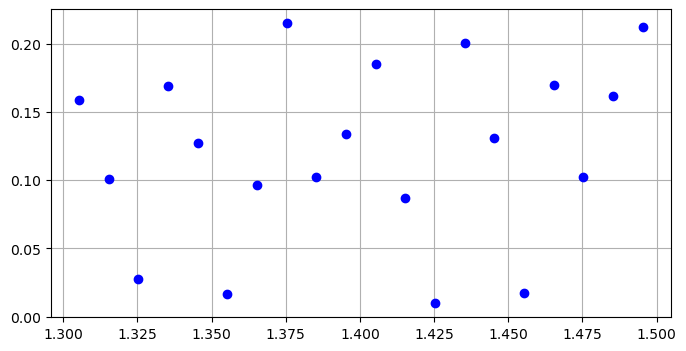

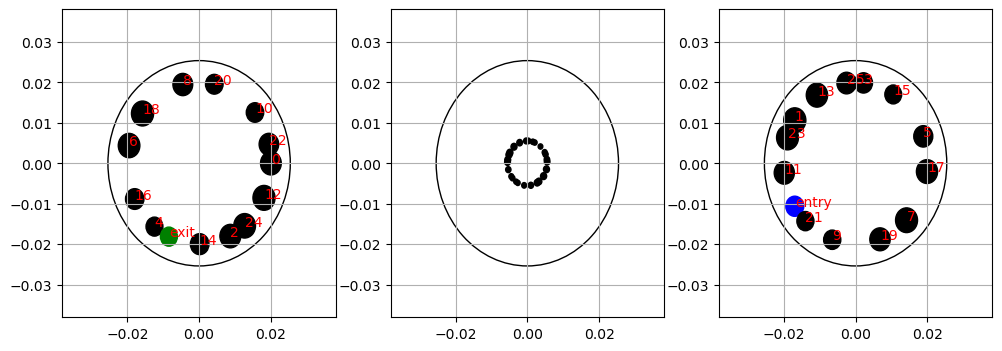

In [29]:
E = 4e-3
tau0 = 450e-15
wl = 1030e-9
M2 = 1.2
zf = 0.5

R = 0.75
Jd = 0.2 *1e4
pressure = 1
n2 = 0.97e-23 #argon
Rmirror = 25.4e-3   ##diamètre 2 pouces

sigma = 1 - (E/tau0)/(3.77*wl**2/(8*np.pi*pressure*n2))

Lmin = 2*R*E**2 / (E**2 + wl**2*R**2*Jd**2)
Lmax = 1.999*R
dL = 0.01

lL = np.arange(Lmin, Lmax, dL)
lK = []
lwm = []
lfl = []
l_dthetas = []
N = 26
for iL in range(len(lL)):
    L = lL[iL]


    Cavity = cavity(L=L, RCmirror=R, Rmirror=Rmirror, pressure=pressure, n2=n2, sc=3)
    Cavity.injection_laser(x_in=20e-3, y_in=0, thetax_in=0, thetay_in=0, E=E, wl=wl, w0=200e-6, tau0=tau0, z=zf*L, M2=M2)
    w0 = Cavity.optimize_waist()
    Cavity.optimize_injection(N)
    
    # print(f'waist = {w0*1e6}µm')
    # w = w0*(1+L**2/4/(np.pi*w0/wl))
    # print(f'waist on mirror = {w*1e6}µm')


    waist_mirror, fluence = Cavity.waists(show=False)
    _, l_thetas, _, _, _ = Cavity.propag_MPC(N, show=False)
    K = Cavity.Bint / np.pi
    lK.append(K)
    lwm.append(waist_mirror)
    lfl.append(fluence)
    # lfl2.append(E/(M2*np.pi*waist_mirror**2))
    l_thetas_ordered = np.sort(l_thetas)
    l_dthetas.append(np.min(arr([l_thetas_ordered[i]-l_thetas_ordered[i-1] for i in range(1, len(l_thetas))])))
    # plt.plot(l_thetas_ordered)
    # plt.plot(l_thetas_ordered)

lK = arr(lK)
lwm = arr(lwm)
lfl = arr(lfl)
l_dthetas = arr(l_dthetas)
print(lK)
print(lwm*1e6)
print(lfl/Jd)
print(l_dthetas)
print((-l_dthetas).argmin())


1.3752682530208122


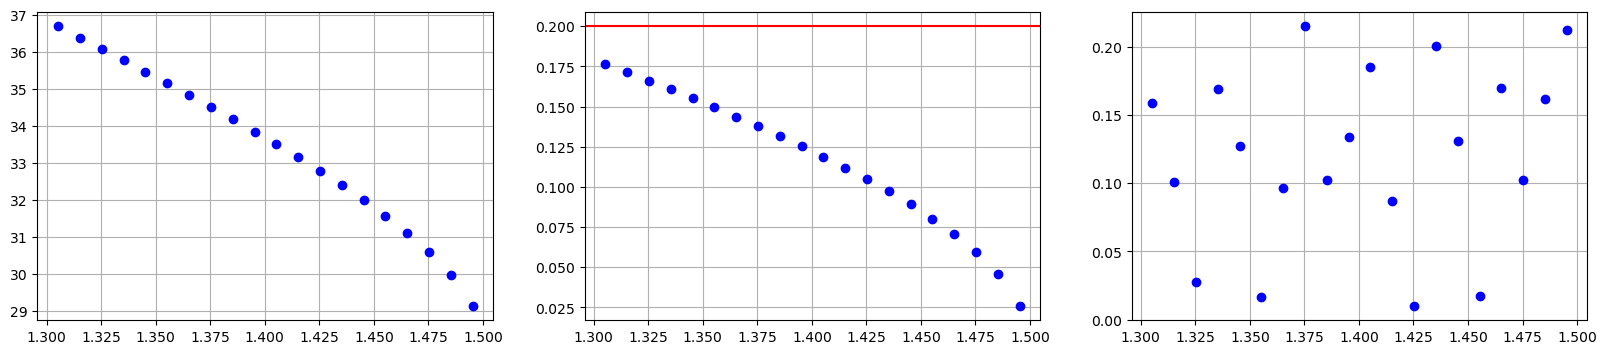

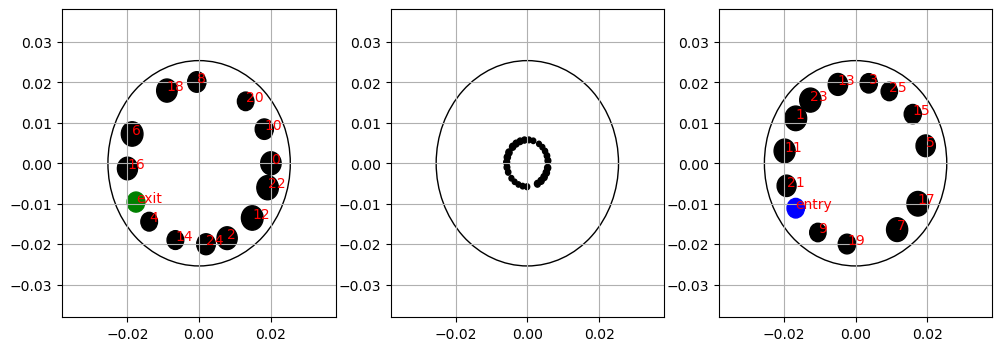

In [32]:
f, axes = plt.subplots(1,3, figsize=(20,4))
ax_tau = axes[0]
ax_fluence = axes[1]
ax_dtheta = axes[2]

ax_tau.plot(lL, tau0/lK*1e15, 'ob')
ax_fluence.plot(lL, lfl*1e-4, 'ob')
ax_fluence.axhline(y=Jd*1e-4, color='r')
ax_dtheta.plot(lL, l_dthetas, 'ob')

L_opt = 1.375
L_opt = lL[(-l_dthetas).argmin()]
print(L_opt)


Cavity = cavity(L=L_opt, RCmirror=R, Rmirror=Rmirror, pressure=pressure, n2=n2, sc=3)
Cavity.injection_laser(x_in=20e-3, y_in=0, thetax_in=0, thetay_in=0, E=E, wl=wl, w0=200e-6, tau0=tau0, z=zf*L, M2=M2)
w0 = Cavity.optimize_waist()
Cavity.optimize_injection(N)
_, _, _, _, _ = Cavity.propag_MPC(N, show=True)
